#### Question 1 
Listening behavior on playlists is analyzed using the following tables:
- playlists​ table with columns:
    ○ user_id ​ : the user who uploaded the playlist
    ○ playlist_id ​ : the unique identifier of the playlist
    
- listings ​ table with columns:
    ○ playlist_id ​ : the unique identifier of the playlist
    ○ track_id ​ : the unique identifier of the track
    ○ position ​ : the position of this track in the playlist
    ○ track_duration ​ : the length of the track recording (in milliseconds)
    
- plays ​ table with columns:
    ○ timestamp ​ : the time the play occurred
    ○ user_id ​ : the user who played the given track
    ○ track_id ​ : the unique identifier of the track
    ○ playlist_id ​ : the unique identifier of the playlist (0 if the play did not happen in a playlist)
    ○ listening_duration ​ : the duration that the user listened to the track (in milliseconds)

Using this schema, write or describe a SQL query that would help you find out the following:

#### What are the 5 most listened to playlists?
-----------


SELECT playlist_id, SUM(playlist_id) FROM plays

WHERE playlist_id != 0

GROUPBY playlist_id

SORT DESCENDING

LIMIT 5;

#### Given a user X, what are their 3 most listened to playlists?
-----------


SELECT playlist_id, SUM(playlist_id) FROM plays

WHERE user_id = X 

AND playlist_id != 0

GROUPBY playlist_id

SORT DESCENDING

LIMIT 3;

#### For a user X, recommend 5 playlists they would like that they haven’t heard before. You can attempt this via SQL or any other programming language of your choice. Please explain your logic.
-----------


SQL isn't a great language for personalized recommender systems. But since this is the SQL section, I'll pick the simplest approach to the question that I can do in SQL. I'm going to recommend the most popular playlists that the user hasn't listened to. This has the major drawback of the fact that there is no personalization involved with this approach. But I can do it quickly and in SQL.

We're going to take the top query and exclude the playlists in the second query from the top query.

------------

SELECT playlist_id FROM plays

WHERE playlist_id != 0 

AND playlist_id NOT IN 

(

SELECT playlist_id FROM plays

WHERE user_id = X

GROUPBY playlist_id

)

SORT DESCENDING

LIMIT 5;

#### Question 2
Consider the following: the Growth team at NoiseNimbus has the goal of increasing downloads of
the NoiseNimbus mobile apps by 20% within the next 3 months. The product manager has
proposed several new features she believes will drive this growth. As a data scientist embedded
in this team, how would you work with the team’s product manager and engineers to contribute
to the most successful outcome? We’re looking for a short description of any questions you would ask, processes/tools you would put in place, and analyses you would prioritize.

#### Answer
Are mobile downloads the only KPI? I'd look at historically, what factors have lead to increased mobile downloads. I'd look at past downloads and build a model with downloads as the target and look at the features that contributed to downloads. I'd see if the product manager's features are in line with this. Going forward I would set sub-KPIs that look at the contributing features to download. For instsance, perhaps downloading is correlated with x minutes per month of listening. I'd be monitoring for these signs from users. I'd also look at ways of engaging with users that are in line with achieving the sub-KPIs of user downloads. Working with product managers and engineers, I'd make sure the platform is doing that, monitoring it consistently and adjusting as necessary. I'd want to understand if users from a particular area or demographic are more likely to download and study those users, perhaps surveying them to better understand their behavior and see if there are ways we could influence other users to behave accordingly.

#### Question 3

We would like to know what factors affect a listener’s choice to skip a recommended track.
In this dataset, each record (i.e., each sub-list of the “data” field) represents the total amount of
time the user spent listening to a track that had been recommended before a different track was
played or the listening session ended.

The provided attributes (in the “columns” field) are:

- ts ​ : the time the user listened to the recommended track (as Unix timestamp)
- country_code ​ : the two-character country abbreviation where the user was located at the time of listening
- client_version ​ : the version of the client that the listener was using
- listening_context ​ : the section of the NoiseNimbus web app where the user listened to the recommended track
    ○ “collection”: any of the pages in the ​ Collection section
    ○ “you”: the listener’s ​ own profile page
    ○ “search”: any of the pages in the ​ Search experience
    ○ “stream”: the page of the ​ Stream experience
    ○ “personal-recommended’: the page of the ​ Discover experience​ for personalized recommendations
    ○ “charts”: the page of the ​ Charts experience​ for trending content discovery
    ○ “tracks”: the dedicated page of an uploaded track
    ○ “users”: the profile page of another user (not the one listening)
    ○ “playlists”: the dedicated page of a playlist
- recommender_algorithm_name ​ : the name of the algorithm that produced the track recommendation for the listener
    ○ “content-based”: an implementation of content-based filtering
    ○ “collaborative”: an implementation of collaborative filtering
    ○ “hybrid”: a hybrid implementation of content-based and collaborative filtering
    ○ “fallback”: a static list of the popular tracks, used only as a fallback strategy
- track_id ​ : the unique identifier of the recommended track
- track_genre_category ​ : the broad genre category describing the recommended track
- track_upload_date ​ : the date the recommended track was uploaded (as Unix timestamp)
- track_duration ​ : the length of the recommended track recording (in milliseconds)
- listen_duration ​ : the duration that the user listened to the recommended track (in milliseconds)
- listener_id ​ : the unique identifier of the user who listened to the recommended track
- listener_signup_date ​ : the date the listener created their NoiseNimbus account (as Unix timestamp)
- listener_top_genre_category_listened ​ : the genre category that the user has most frequently listened to (based on all their past listening in all contexts)
- listener_prev_month_listening_time ​ : the total duration that the user listened in the previous month (in all contexts)
- listener_prev_month_avg_daily_tracks_listened ​ : the daily mean number of distinct tracks that the user listened in the previous month (in all contexts) Using this dataset and a programming language of your choice, produce a model that can predict whether or not a user will ​ skip​ past a recommended track.


The goal is ​ not​ to produce a model that can predict with >90% accuracy or that is optimized for speed, but rather to produce a model that is both interpretable and more accurate than either a uniform random model or a model that always predicts 0.


While there is no official definition of a skip, you can develop an operational definition based on ​ track_duration ​ and ​ listen_duration ​ Based on the model you build, please explain any insights Noise Nimbus’s Recommendations team could use to decrease skip rate, as well as any additional analyses you would perform to better understand skip behavior.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels import robust
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
#load the data

df = pd.read_json("sc_data_science_challenge.json", orient='split')

In [3]:
df.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened
0,1467398683,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,1466640000,413933,413933,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
1,1467398924,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,1466726400,402640,110722,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
2,1467820636,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,1467072000,494811,193818,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
3,1467401951,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,1402272000,361585,361585,000264c5b34ad04999535c8b6a8b86e2,1379376000,HipHop & R&B,112239180.0,10.5
4,1467402159,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,1448668800,373700,160162,000264c5b34ad04999535c8b6a8b86e2,1379376000,HipHop & R&B,112239180.0,10.5


In [4]:
# to understand skips, the most important aspect is going to be looking at the listen to duration ratio

df['listen_ratio'] = df.listen_duration/df.track_duration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828169 entries, 0 to 828168
Data columns (total 16 columns):
ts                                               828169 non-null int64
country_code                                     828169 non-null object
client_version                                   828169 non-null object
listening_context                                828169 non-null object
recommender_algorithm_name                       828169 non-null object
track_id                                         828169 non-null object
track_genre_category                             828169 non-null object
track_upload_date                                828169 non-null int64
track_duration                                   828169 non-null int64
listen_duration                                  828169 non-null int64
listener_id                                      828169 non-null object
listener_signup_date                             828169 non-null int64
listener_top_genre_category_li

In [6]:
#we're getting some funky results--like infinity--in the listen ratio column for 629 variables 
#because the track duration is listed as 0 and the listen_duration is listed in positive seconds

inf_df = df[df['listen_ratio'] == np.inf]
print(len(inf_df))

#we're going to get rid of these erroneous rows

df = df[df['listen_ratio'] != np.inf]

629


In [7]:
#we're also getting errors in the listen duration column because the track is listed as a zero duration

null_df = df[df['listen_ratio'].isnull()]
print(len(null_df))

#we're going to get rid of these columns as well

df = df[np.isfinite(df['listen_ratio'])]

10


In [8]:
#filling in nulls with zeros

df = df.fillna(value=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827530 entries, 0 to 828168
Data columns (total 16 columns):
ts                                               827530 non-null int64
country_code                                     827530 non-null object
client_version                                   827530 non-null object
listening_context                                827530 non-null object
recommender_algorithm_name                       827530 non-null object
track_id                                         827530 non-null object
track_genre_category                             827530 non-null object
track_upload_date                                827530 non-null int64
track_duration                                   827530 non-null int64
listen_duration                                  827530 non-null int64
listener_id                                      827530 non-null object
listener_signup_date                             827530 non-null int64
listener_top_genre_category_li

In [10]:
#the data still has inconsistencies and errors
#the listen ratio should be between 0 and 1, but it's between 351 and -0.999

print(df.listen_ratio.max())
print(df.listen_ratio.min())

351.2744816013424
-0.09999892713647361


In [11]:
#getting rid of erroneous listen times
#the listen ratio should be between 0 and 1

df = df[(df['listen_ratio'] >= 0) & (df['listen_ratio'] <=1)]

In [12]:
#converting timestamps to datetime
#looking at timestamps, we only have the date, not minute or second information for
#user signups and for track upload date

df['ts_dt'] = pd.to_datetime(df['ts'],unit='s')
df['upload_date_dt'] = pd.to_datetime(df['track_upload_date'],unit='s')
df['signup_date_dt'] = pd.to_datetime(df['listener_signup_date'], unit='s')

In [13]:
#we're going to see if the year, month or day of week of 
#the listen date, the upload or signup date have an impact on skipping

df['ts_year'] = df['ts_dt'].dt.strftime('%y').astype(int)
df['upload_year'] = df['upload_date_dt'].dt.strftime('%y').astype(int)
df['signup_year'] = df['signup_date_dt'].dt.strftime('%y').astype(int)
df['ts_month'] = df['ts_dt'].dt.strftime('%-m').astype(int)
df['upload_month'] = df['upload_date_dt'].dt.strftime('%-m').astype(int)
df['signup_month'] = df['signup_date_dt'].dt.strftime('%-m').astype(int)
df['ts_day'] = df['ts_dt'].dt.strftime('%w').astype(int)
df['upload_day'] = df['upload_date_dt'].dt.strftime('%w').astype(int)
df['signup_day'] = df['signup_date_dt'].dt.strftime('%w').astype(int)

In [14]:
#we have a clean dataframe with no nulls

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810053 entries, 0 to 828168
Data columns (total 28 columns):
ts                                               810053 non-null int64
country_code                                     810053 non-null object
client_version                                   810053 non-null object
listening_context                                810053 non-null object
recommender_algorithm_name                       810053 non-null object
track_id                                         810053 non-null object
track_genre_category                             810053 non-null object
track_upload_date                                810053 non-null int64
track_duration                                   810053 non-null int64
listen_duration                                  810053 non-null int64
listener_id                                      810053 non-null object
listener_signup_date                             810053 non-null int64
listener_top_genre_category_li

In [15]:
#looking at track duration to better understand skips

print(df.track_duration.max())
print(df.track_duration.min())

42004074
89


In [16]:
#eliminating tracks that are less than one second long
#these are likely in error

df = df[df['track_duration'] >= 1000]

### I define a skip as any time the listener abandons a song before the song finishes. 
It could be because the listener explicitly presses the skip button, or it could be that they searched for
and started another song before the current song finished, or they clicked on a different song in the playlist.

I'm not eliminating the really long or really short tracks (as long as they're longer than 1 second) from this dataset. Eliminating really long or short tracks would probably lead to less bias towards skipping the longer the track is.  In future analyses, I'd probably limit track length to one or two median absolute deviations from the median and/or find an alternate means of differentiating songs from mixes. The longer the track the more likely it is skipped, but when we don't differentiate between songs and longer mixes, we're not comprehensively understanding skipping behaviour. People are less likely to listen to a mix all the way through than a single song, but I also understand that NoiseNimbus is top online platform for longer independent DJs to post longer mixes. So I'd like to differentiate between songs and mixes in future analyses.

### Preparing the Data for Modeling

In [17]:
#setting target variable by letting all listen_ratio values less than 1 become zero values

df['skipped'] = df['listen_ratio'].astype(int)

In [18]:
#making a copy of the dataframe before beginning to prepare for modeling

df_orig = df.copy(deep = True)

In [19]:
#encoding labels

le = LabelEncoder()
df['country_code'] = le.fit_transform(df['country_code'])
df['client_version'] = le.fit_transform(df['client_version'])
df['listening_context'] = le.fit_transform(df['listening_context'])
df['recommender_algorithm_name'] = le.fit_transform(df['recommender_algorithm_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_genre_category'] = le.fit_transform(df['track_genre_category'])
df['listener_id'] = le.fit_transform(df['listener_id']) 
df['listener_top_genre_category_listened'] = le.fit_transform(df['listener_top_genre_category_listened'])

In [21]:
df.tail()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,...,ts_year,upload_year,signup_year,ts_month,upload_month,signup_month,ts_day,upload_day,signup_day,skipped
828164,1469210707,0,144,6,1,372461,7,1306540800,376736,376736,...,16,11,14,7,5,11,5,6,1,1
828165,1469210923,1,144,6,1,115912,0,1293148800,332924,332924,...,16,10,14,7,12,11,5,5,1,1
828166,1469211113,1,144,6,1,56300,0,1410220800,324144,324144,...,16,14,14,7,9,11,5,2,1,1
828167,1469211300,0,144,6,1,118332,7,1357171200,269325,269325,...,16,13,14,7,1,11,5,4,1,1
828168,1469211451,0,144,6,1,76666,7,1306713600,398321,379204,...,16,11,14,7,5,11,5,1,1,0


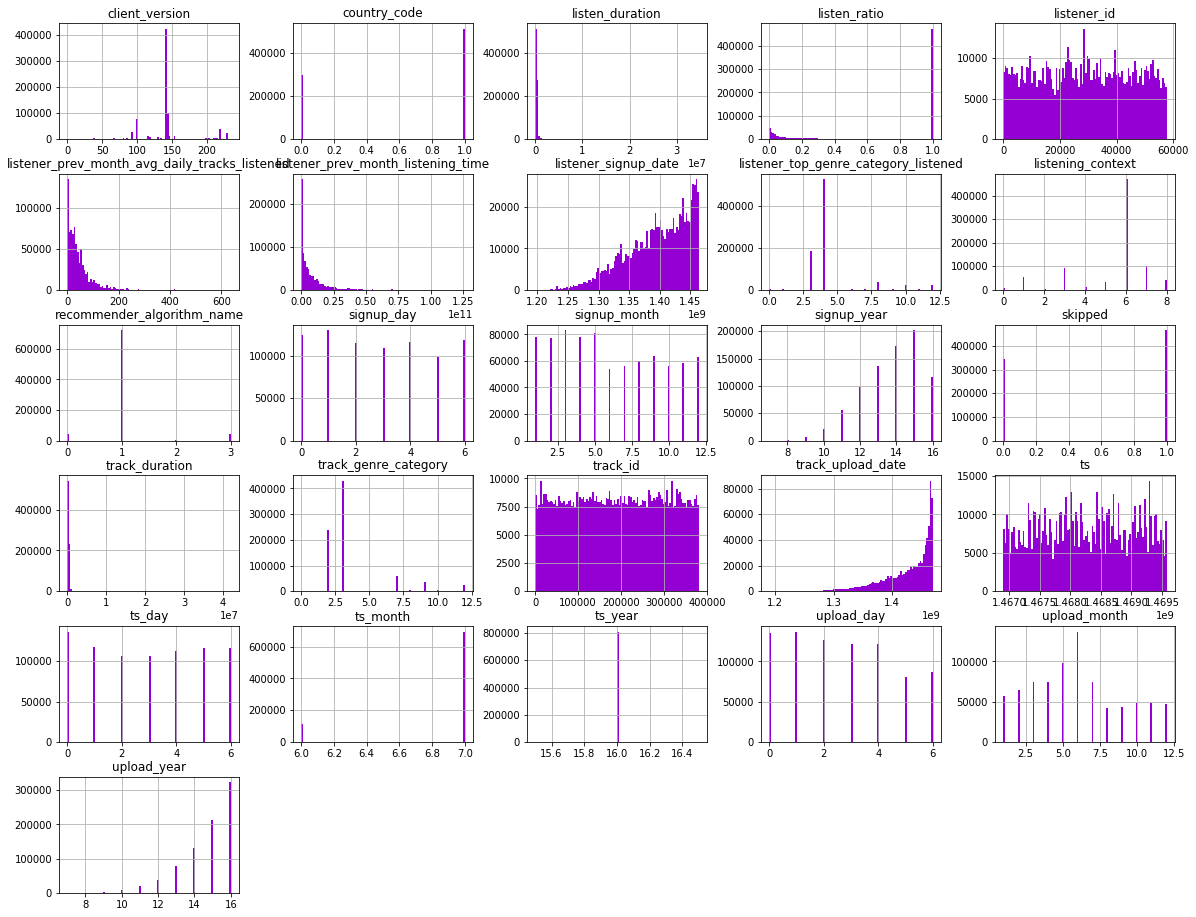

In [97]:
#looking at distributions

df.hist(figsize=(20,16), color='darkviolet', bins=100);

#### overall, the data distributions are skewed and unevenly binned; tree algorithms will probably do well with this sort of data 
#### I will not be including ts_year and ts_month in the model. There aren't enough variables.

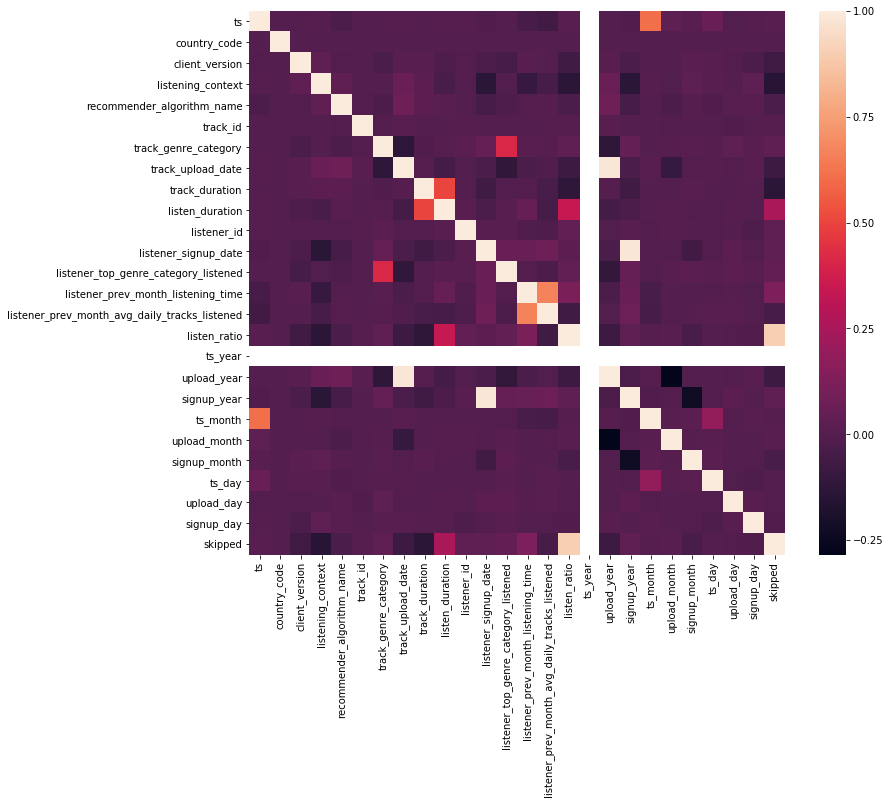

In [24]:
#looking at correlations to prevent colinearity and for feature engineering

fig, ax = plt.subplots(figsize=(12,10))  
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

- I'm not including listen_ratio due to colinearity with listen_duration and track duration
- I'm not including listener id and track id, because those variables seem to be random
- I'm also not going to include listener_signup_date and track_upload_date to avoid colinearity with the day/month/year time elements
- Listen duration and track duration are correlated and somewhat explains skipping - longer tracks are more likely to be skipped and shorter tracks are less likely to be skipped - so I can't include both of these variables.
- I'm seeing corrlations in prev_month_listening_time and prev_month_avg_tracks, so eliminating prev_month_listening_time because prev_month_avg_daily_tracks_listened is representative of almost the same information, but binned

In [104]:
#converting float to int

df['listener_prev_month_listening_time'] = df['listener_prev_month_listening_time'].astype(int)
df['listener_prev_month_avg_daily_tracks_listened'] = df['listener_prev_month_avg_daily_tracks_listened'].astype(int)

In [105]:
#set up data for modeling

y = df['skipped'].values
X = df[['country_code', 'client_version', 'listening_context','recommender_algorithm_name',
       'track_genre_category', 'track_duration','listener_top_genre_category_listened',
        'listener_prev_month_avg_daily_tracks_listened','upload_year', 'signup_year','upload_month', 
        'signup_month', 'upload_day', 'signup_day', 'ts_day']]

#min max scaler

X = MinMaxScaler().fit_transform(X)

#test-train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [340]:
#choosing some Classifcation Algorithms that I like for this problem 
#and looking at their accuracy scores
#I'm choosing 2 linear models and 4 Ensemble/Tree algorithms
#Logistic, Ridge, Adaptive Boosting, Decision Tree, Random Forest, 
#and Extremely Randomized Trees
#I suspect the Ensemble/Tree algorithms will do better

models = [LogisticRegression(penalty='l1'),  #L1 regularization
          RidgeClassifier(solver="lsqr"),    #L2 regularization
          AdaBoostClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_jobs=-1),
          ExtraTreesClassifier(n_jobs=-1)
         ]

res = []

for model in models:
    print model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print score
    res.append([model, score])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6000665913461178
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.001)
0.5984878526909638
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
0.66556554010071
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7630096295575791
RandomForestC

let's look at better performing algorithms - As predicted, tree algorithms did better with this data

In [106]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = accuracy_score(y_test, y_pred)
print score

0.7638476330143433


In [107]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print score

0.7886996730290083


In [108]:
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred = et.predict(X_test)
score = accuracy_score(y_test, y_pred)
print score

0.789324434534721


In [364]:
# null accuracy - a dumb model that always predicts 0 would be right ~58% of the time, 
#so these models are all better than a dumb model

print max(y_test.mean(), 1 - y_test.mean())

0.5761647873940338


### The best models are Random Forest and Extra Trees. Either of these are better than a dumb model and run fairly quickly. With these models, you need to be careful about overfitting, but they are fine for our current purpose.

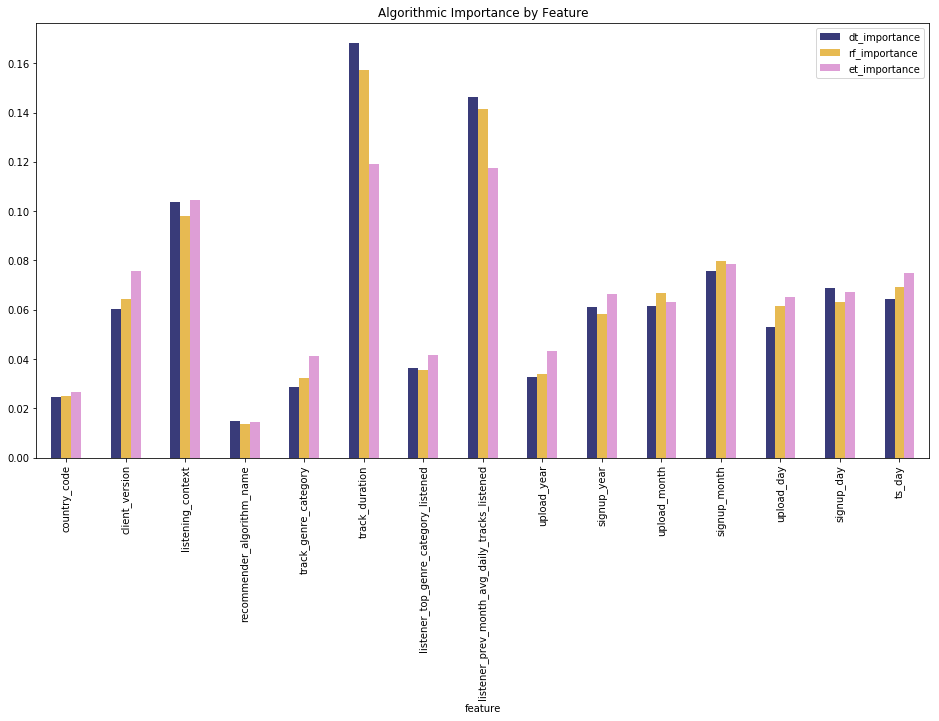

In [109]:
#Algorithmic Importance by Feature so we can understand track skipping

cols = ['country_code', 'client_version', 'listening_context','recommender_algorithm_name',
       'track_genre_category', 'track_duration','listener_top_genre_category_listened',
        'listener_prev_month_avg_daily_tracks_listened','upload_year', 'signup_year',
        'upload_month', 'signup_month', 'upload_day', 'signup_day', 'ts_day']

features = pd.DataFrame(zip(cols, np.transpose(dt.feature_importances_),
                 np.transpose(rf.feature_importances_), 
                 np.transpose(et.feature_importances_) ), 
             columns = ['feature', 'dt_importance', 'rf_importance', 'et_importance'])
features = features.set_index('feature')
features.plot(kind='bar', colormap='tab20b', title='Algorithmic Importance by Feature', figsize = (16,8));

### Conclusion
I ran the model several times with different features, and this was one of the better runs to understand the features. The Track Duration and previous month's Average Daily Tracks Listened have the biggest impact on track skips, as does Listening Context, Client Version and Signup Month.

Sadly, the recommender algorithms seem to have little effect on a user skipping tracks or not. Also, the location, genre, top genre and timing of everything except the signup month and maybe track upload month seems to have little to no effect on a user skipping tracks. 

I want to dive further into the Previous Month's Average Daily Tracks, Listening Context and Signup Month.

In [23]:
df2 = df_orig[['listening_context', 'listener_prev_month_avg_daily_tracks_listened', 'signup_month']]

In [24]:
df3 = pd.get_dummies(df2, drop_first=True)

In [25]:
df3.head()

,listener_prev_month_avg_daily_tracks_listened,signup_month,listening_context_collection,listening_context_personal-recommended,listening_context_playlists,listening_context_search,listening_context_stream,listening_context_tracks,listening_context_users,listening_context_you
0,22.5,12,0,0,0,0,0,1,0,0
1,22.5,12,0,0,0,0,0,1,0,0
2,22.5,12,0,0,0,0,0,0,1,0
3,10.5,9,1,0,0,0,0,0,0,0
4,10.5,9,1,0,0,0,0,0,0,0


In [26]:
#our base case is: charts

df_orig['listening_context'].unique()

array([u'tracks', u'users', u'collection', u'you', u'search',
       u'playlists', u'stream', u'personal-recommended', u'charts'],
      dtype=object)

In [34]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810005 entries, 0 to 828168
Data columns (total 10 columns):
listener_prev_month_avg_daily_tracks_listened    810005 non-null float64
signup_month                                     810005 non-null int64
listening_context_collection                     810005 non-null uint8
listening_context_personal-recommended           810005 non-null uint8
listening_context_playlists                      810005 non-null uint8
listening_context_search                         810005 non-null uint8
listening_context_stream                         810005 non-null uint8
listening_context_tracks                         810005 non-null uint8
listening_context_users                          810005 non-null uint8
listening_context_you                            810005 non-null uint8
dtypes: float64(1), int64(1), uint8(8)
memory usage: 24.7 MB


In [27]:
df3 = df3.astype(int)

In [28]:
X2 = df3

#min max scaler

X2 = MinMaxScaler().fit_transform(X2)

#test-train split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.33, random_state=42)

In [38]:
models = [LogisticRegression(penalty='l1'),  #L1 regularization
          RidgeClassifier(solver="lsqr"),    #L2 regularization
          AdaBoostClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_jobs=-1),
          ExtraTreesClassifier(n_jobs=-1),
          KNeighborsClassifier()
         ]

res = []

for model in models:
    print model
    model.fit(X2_train, y2_train)
    y2_pred = model.predict(X2_test)
    score = accuracy_score(y2_test, y2_pred)
    print score
    res.append([model, score])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6357041847797622
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.001)
0.6353412993542884
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
0.637503647559689
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7134888627844161
RandomForest

In [66]:
dt = DecisionTreeClassifier()
dt.fit(X2_train, y2_train)
y2_pred = dt.predict(X2_test)
score = accuracy_score(y2_test, y2_pred)
print score

0.7134664162632528


In [67]:
rf = RandomForestClassifier()
rf.fit(X2_train, y2_train)
y2_pred = rf.predict(X2_test)
score = accuracy_score(y2_test, y2_pred)
print score

0.7133317371362728


In [68]:
et = ExtraTreesClassifier()
et.fit(X2_train, y2_train)
y2_pred = et.predict(X2_test)
score = accuracy_score(y2_test, y2_pred)
print score

0.7134963449581372


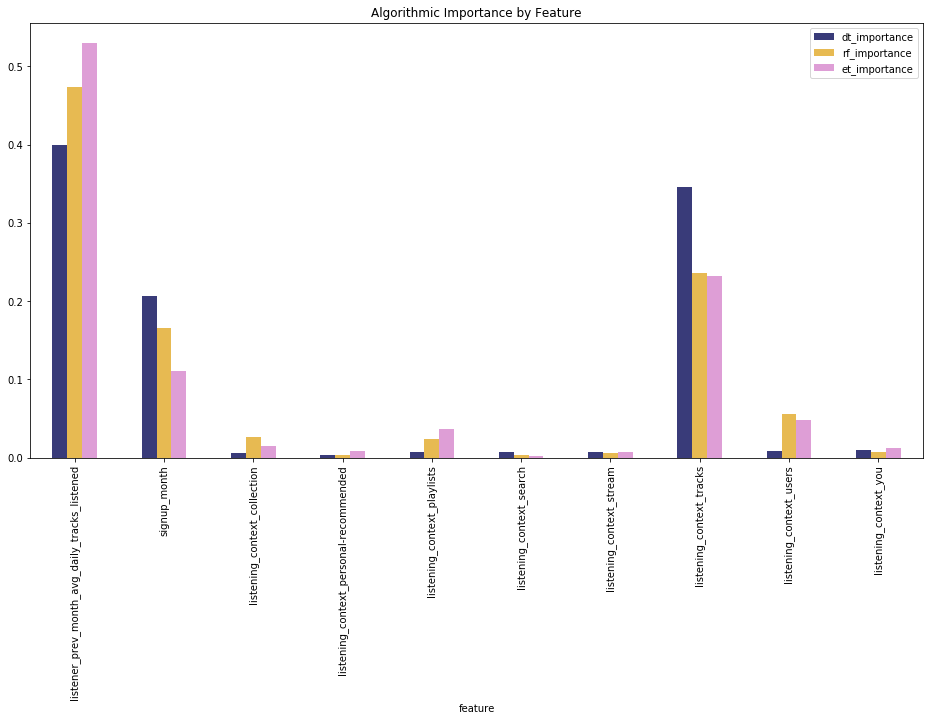

In [77]:
cols=['listener_prev_month_avg_daily_tracks_listened', 'signup_month',
       u'listening_context_collection',
       u'listening_context_personal-recommended',
       u'listening_context_playlists', u'listening_context_search',
       u'listening_context_stream', u'listening_context_tracks',
       u'listening_context_users', u'listening_context_you']

features = pd.DataFrame(zip(cols, np.transpose(dt.feature_importances_),
                 np.transpose(rf.feature_importances_), 
                 np.transpose(et.feature_importances_) ), 
             columns = ['feature', 'dt_importance', 'rf_importance', 'et_importance'])
features = features.set_index('feature')
features.plot(kind='bar', colormap='tab20b', title='Algorithmic Importance by Feature', figsize = (16,8));

### Conclusion:
Compared to our base case, listening_context_charts, the listening_context_of_tracks is important in terms of skipping tracks. Signup month is significant, but not that important so I'm not going to dive deeper into that variable.

In [45]:
#looking at the original dataframe, before we started modeling the data

df_orig.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,...,ts_year,upload_year,signup_year,ts_month,upload_month,signup_month,ts_day,upload_day,signup_day,skipped
0,1467398683,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,1466640000,413933,413933,...,16,16,11,7,6,12,5,4,0,1
1,1467398924,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,1466726400,402640,110722,...,16,16,11,7,6,12,5,5,0,0
2,1467820636,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,1467072000,494811,193818,...,16,16,11,7,6,12,3,2,0,0
3,1467401951,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,1402272000,361585,361585,...,16,14,13,7,6,9,5,1,2,1
4,1467402159,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,1448668800,373700,160162,...,16,15,13,7,11,9,5,6,2,0


### Understanding Track Duration vs Skips

In [22]:
#making a pivot table to understand track duration

lc = pd.pivot_table(df_orig, values='skipped', columns='track_duration', aggfunc=('count', 'sum')).T
lc['skipped'] = lc['count'] - lc['sum']
lc.columns = ['total', 'listened', 'skipped']
lc['skipped%'] = (lc.skipped/lc.total)*100
lc['skipped%'] = lc['skipped%'].round(2)
lc.head()

,total,listened,skipped,skipped%
track_duration,,,,
1050,1,1,0,0.0
1188,1,1,0,0.0
1278,1,1,0,0.0
1507,2,2,0,0.0
1554,3,3,0,0.0


0.1      0.00
0.2     18.18
0.3     33.33
0.4     42.31
0.5     50.00
0.6     66.67
0.7    100.00
0.8    100.00
0.9    100.00
Name: skipped%, dtype: float64


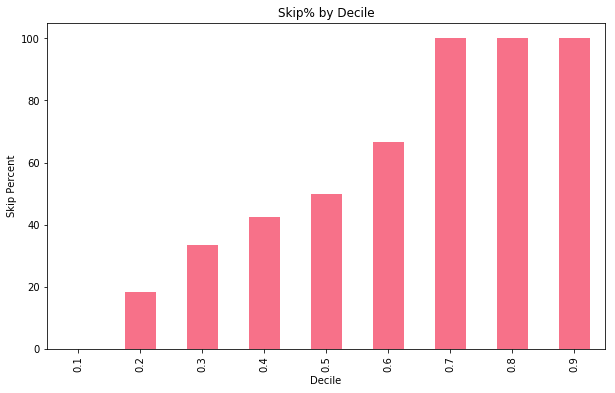

In [26]:
#looking at deciles

decile_skips = lc['skipped%'].quantile(q=[.1,.20,.30,.4,.5,.6,.7,.8,.9])
print(decile_skips)
sns.set_palette("husl")
decile_skips.plot(kind='bar', title='Skip% by Decile', figsize = (10,6))
plt.ylabel('Skip Percent')
plt.xlabel('Decile')
plt.show();

As the track duration increases, the skipped % increases.

### Understanding Listening Context vs Skips

In [27]:
#making a pivot table to understand listening context

lc = pd.pivot_table(df_orig, values='skipped', columns='listening_context', aggfunc=('count', 'sum')).T
lc['skipped'] = lc['count'] - lc['sum']
lc.columns = ['total', 'listened', 'skipped']
lc['skipped%'] = (lc.skipped/lc.total)*100
lc['skipped%'] = lc['skipped%'].round(2)
lc

,total,listened,skipped,skipped%
listening_context,,,,
charts,6294,5701,593,9.42
collection,54866,43550,11316,20.62
personal-recommended,5374,4984,390,7.26
playlists,90459,67174,23285,25.74
search,11131,8168,2963,26.62
stream,31251,21449,9802,31.37
tracks,469190,209955,259235,55.25
users,100100,76868,23232,23.21
you,41340,28703,12637,30.57


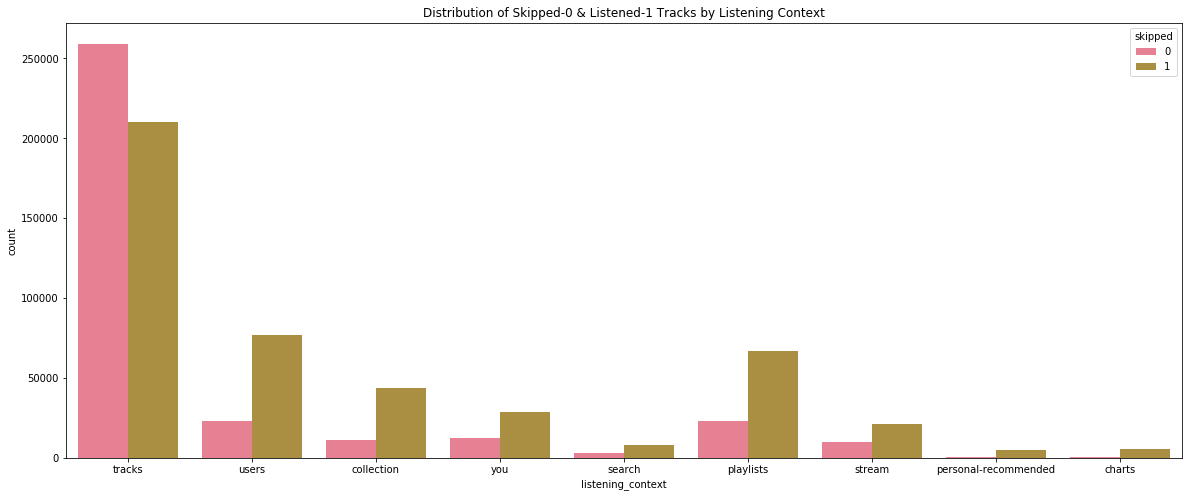

In [28]:
#looking at the count plot, skipped tracks = 0, listened tracks = 1

fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
ax = sns.countplot(x="listening_context", hue='skipped', data=df_orig).set_title("Distribution of Skipped-0 & Listened-1 Tracks by Listening Context");

Users are overwhelmingly listening to more than half of all tracks in all contexts except the "tracks" context

Users are less likely to skip tracks in the "charts" and "personal-recommended" context, skipping less than 10% of all tracks. Users are mostly likely to skip tracks in the "tracks" listening context, skipping 55% of tracks.

Proportionally, listeners listen to the most tracks in "personal-recommendation", "charts", "users" and "collections" contexts, but those contexts don't get a lot of plays overall.


### Understanding Previous Month Average Daily Tracks vs Skips

In [69]:
#looking at previous month average daily tracks listened to skipped tracks in a pivot table

lc = pd.pivot_table(df_orig, values='skipped', 
                    columns='listener_prev_month_avg_daily_tracks_listened', 
                    aggfunc=('count', 'sum')).T
lc = lc.reset_index()
lc['skipped'] = lc['count'] - lc['sum']
lc.columns = ['last_month_avg_daily_tracks','total', 'listened', 'skipped']

#simplifying averages to intergers

lc.last_month_avg_daily_tracks = lc.last_month_avg_daily_tracks.astype(int)

#grouping by integer

lc = lc.groupby(by ='last_month_avg_daily_tracks').sum()
lc['skipped%'] = (lc.skipped/lc.total)*100
lc['skipped%'] = lc['skipped%'].round(2)
lc

,total,listened,skipped,skipped%
last_month_avg_daily_tracks,,,,
0,60407,37572,22835,37.80
1,15611,8027,7584,48.58
3,19391,11234,8157,42.07
4,21316,13336,7980,37.44
6,18161,10187,7974,43.91
7,18166,10622,7544,41.53
9,17972,10135,7837,43.61
10,16903,9571,7332,43.38
12,17710,10052,7658,43.24


In [70]:
lc.describe()

,total,listened,skipped,skipped%
count,182.000000,182.000000,182.000000,182.000000
mean,4450.576923,2563.472527,1887.104396,53.056923
std,7165.608985,4316.429043,2894.190045,25.740376
min,1.000000,0.000000,1.000000,2.960000
25%,157.000000,46.250000,58.750000,36.687500
50%,1107.000000,561.000000,537.500000,45.100000
75%,5753.750000,3391.750000,2551.500000,70.357500
max,60407.000000,37572.000000,22835.000000,100.000000


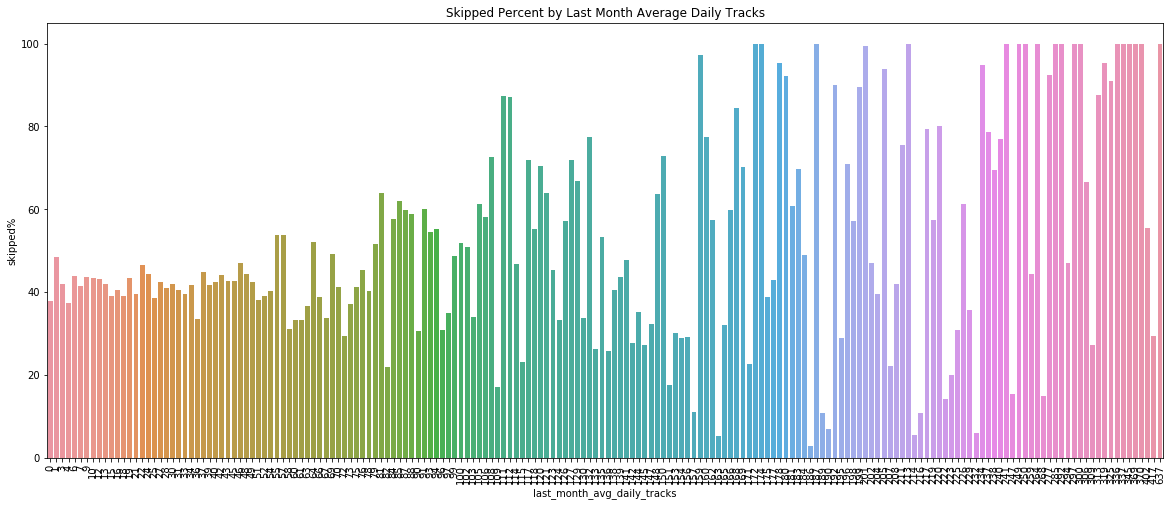

In [71]:
#barplot looking at the skipped % per last month average daily tracks

y=lc['skipped%']
x=lc.index

fig, ax = plt.subplots(figsize=(20,8))
ax.set_xticklabels(x, rotation=90)
sns.barplot(x,y, data=lc).set_title("Skipped Percent by Last Month Average Daily Tracks");

LinregressResult(slope=0.10977262270961044, intercept=37.07897500988852, rvalue=0.4262021662674043, pvalue=1.9884911839329137e-09, stderr=0.017366493306871154)


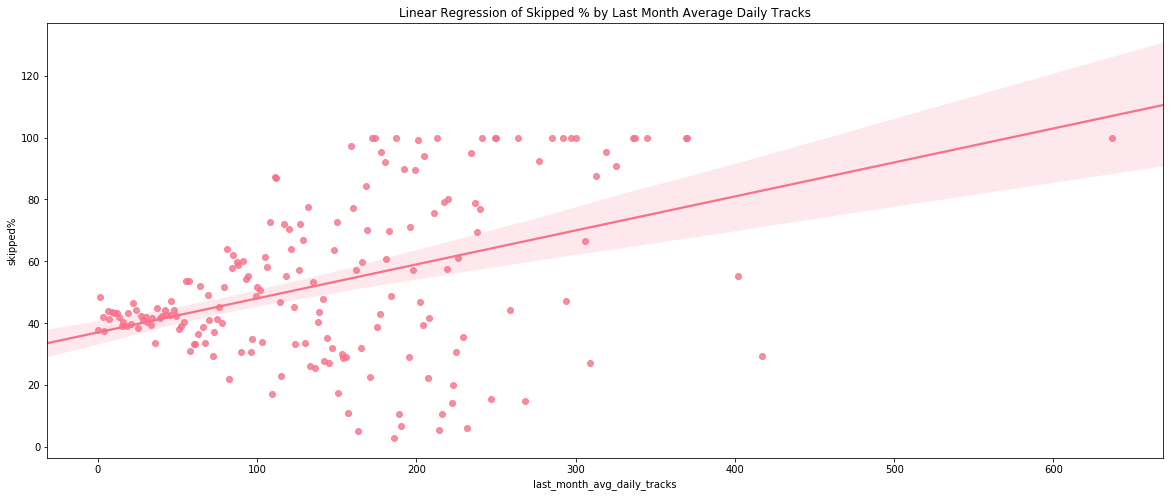

In [72]:
#simple linear regression visualizing the relationship 
#between total tracks listened and last month average daily tracks

#resetting index

lc2 = lc.reset_index()
lc2.last_month_avg_daily_tracks = lc2.last_month_avg_daily_tracks.astype(int)

#setting variables

y=lc2['skipped%']
x=lc2['last_month_avg_daily_tracks']

#line regress in SciPy

print(linregress(x, y))

#visualizing the regression of these 2 variables

fig, ax = plt.subplots(figsize=(20,8))
sns.regplot(x,y, data=lc2).set_title("Linear Regression of Skipped % by Last Month Average Daily Tracks");

#### There is a moderate and positive correlation between these two variables (0.42) that is statistically significant due to the p-value (1.99^10-09).  We can see a moderate and slow increase in skipped % as the number of last month average listening increases due to the slope (0.11).

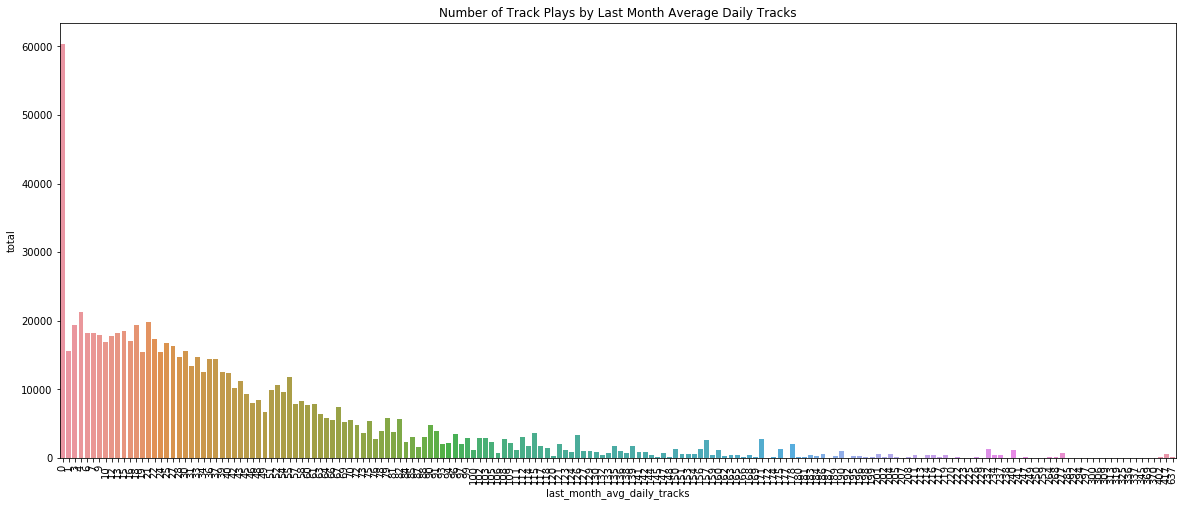

In [73]:
#barplot looking at last month average daily tracks by track plays
#there are fewer listeners listening to more tracks

y=lc['total']
x=lc.index

fig, ax = plt.subplots(figsize=(20,8))
ax.set_xticklabels(x, rotation=90)
sns.barplot(x,y, data=lc).set_title("Number of Track Plays by Last Month Average Daily Tracks");

LinregressResult(slope=-46.3504861206202, intercept=11197.119383633788, rvalue=-0.6464540875081802, pvalue=6.448961493269051e-23, stderr=4.077350794525077)


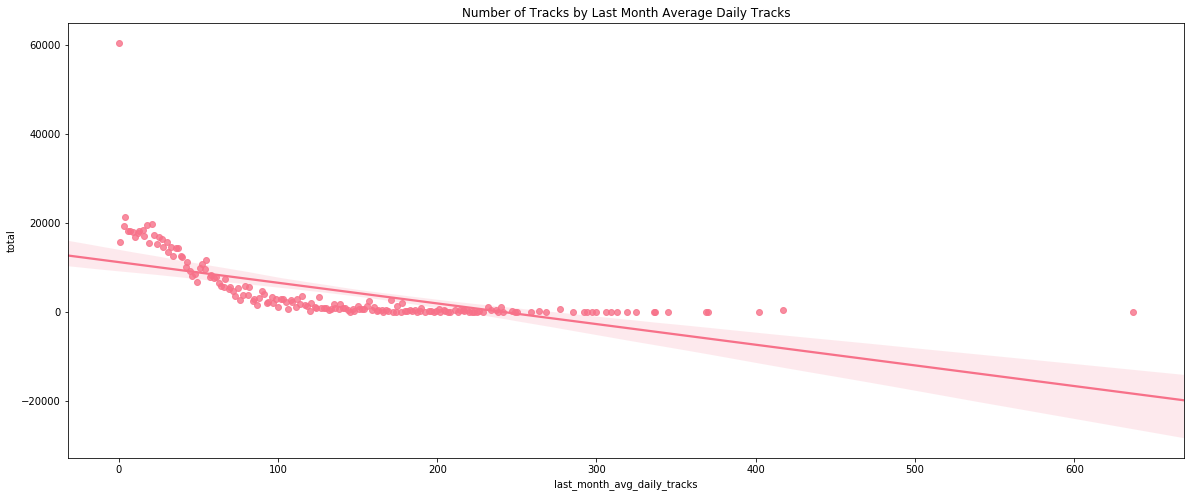

In [74]:
#simple linear regression visualizing the relationship 
#between total tracks listened by last month average daily tracks

y=lc2['total']
x=lc2['last_month_avg_daily_tracks']

#line regress in SciPy

print(linregress(x, y))

#visualizing the regression of these 2 variables

fig, ax = plt.subplots(figsize=(20,8))
sns.regplot(x,y, data=lc2).set_title("Number of Tracks by Last Month Average Daily Tracks");

#### There is a moderate to strong negative correlation between listened tracks and last month average daily tracks (-0.65) that is also statistically significant due to the p-value (6.44^10-23).  The slope is dramatic (-46.35) suggesting a fast drop off where fewer tracks are played in the context of more listening last month and more tracks are played in the context of having not listened to many tracks last month. Conversely, as last month's average daily tracks decreases, listening increases. 

#### Previous Month Average Daily Tracks vs Skips in Conclusion:
Fewer tracks listened to every day last month indicates a skipped rate of around 40%. But as users listen to more recommended tracks, there is more variance in skip percent and skip percent increases. Why do users that listen more recommended tracks skip more and exhibit more diverse behaviours therein?

Also, why do a lot of users that listen heavily one month drop off the next? In the second chart, we're seeing that most recommended tracks are played in the context of fewer tracks listened to last month. But by pivoting the "last month average tracks" column, we're pivoting an average which can be problematic, but it works for illustrative purposes here. I'd probably do a deeper investigation of this metric with the raw data. We can note that the majority of users are skipping 40% of the tracks and have listened to between zero and less than 100 tracks last month. Both of these effects are statistically significant.

### Understanding Client Version vs Skips

In [63]:
#making pivot table of binned client version to skipped tracks

lc = pd.pivot_table(df_orig, values='skipped', columns='client_version', aggfunc=('count', 'sum')).T
lc['skipped'] = lc['count'] - lc['sum']
lc.columns = ['total', 'listened', 'skipped']

#seeing a lot of random client versions, so trying to eliminate ones that aren't used much

lc = lc.reset_index()

#stripping the value at the decimal point

sep = '.'
lc.client_version = [s.split(sep, 1)[0] for s in lc.client_version]

#converting to integer

lc.client_version = lc.client_version.astype(int)

#grouping by integer

lc = lc.groupby(by ='client_version').sum()

#looking at skip to total songs ratio

lc['skipped%'] = (lc.skipped/lc.total)*100
lc['skipped%'] = lc['skipped%'].round(2)
lc

,total,listened,skipped,skipped%
client_version,,,,
0,197,90,107,54.31
16,249,200,49,19.68
20,227,108,119,52.42
24,2594,1238,1356,52.27
28,2044,986,1058,51.76
32,10177,5530,4647,45.66
36,54237,22634,31603,58.27
40,1053,698,355,33.71
44,24475,16103,8372,34.21


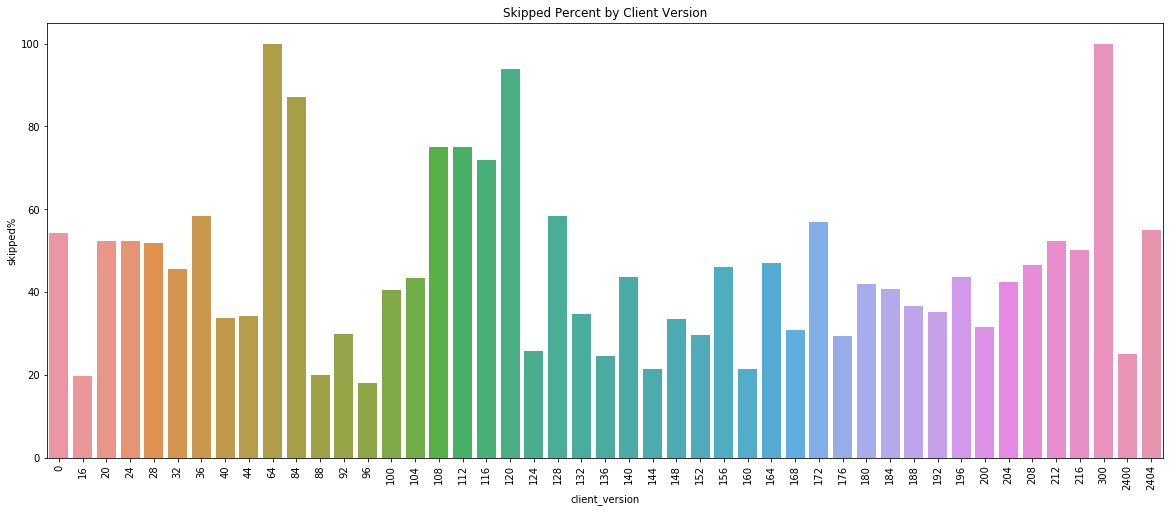

In [64]:
#barplot of binned client versions to % tracks skipped

y=lc['skipped%']
x=lc.index

fig, ax = plt.subplots(figsize=(20,8))
ax.set_xticklabels(x, rotation=90)
sns.barplot(x,y, data=lc).set_title("Skipped Percent by Client Version");

I'm not seeing a clear relationship of client version to skip ratio. I'd need a better understanding of how best to bin the many client versions, if I were to investigate this further.

### Conclusion

Overall, the biggest predictor of skipping a track is the duration of the track--Noise Nimbus users are also more likely to skip longer tracks than shorter tracks. This should be broken down further into skip rates for longer mixes as opposed to shorter songs. I'd expect mixes have a higher skip rate than tracks, because they are longer and often have more diverse content on them.

Other predictors of skipping are the average number of tracks listened to last month. With fewer average tracks listened to last month, the skip rates hover around 40%. Skip rates demonstrate more variance and increase when the average number of tracks listened to last month increases. This should be investigated. Why does behaviour diverge in heavy users? Why do a lot of users drop off in engagement after listening heavily one month? What could make NoiseNimbus more sticky, and user engagement more consistent?

Another predictor of skipping is the listening context. Tracks has the highest skip rate and also the highest number of plays. The other listening contexts have much lower skip rates and overall lower numbers of plays.

There is probably a relationship between client version and skipping tracks but I don't have the context to understand it without a more comprehensive understanding of how I could best bin client versions to see that pattern.

To decrease skip rate, the best things NoiseNimbus can do is find ways to increase user engagement in listening contexts that aren't tracks. They have a much lower skip rate as well as lower user engagement. I believe that in finding ways of increasing user engagement on those listening contexts, we could lower overall skip rates.

I'm also not understanding why some users that listen to more recommended tracks per day have more divergent behaviour regarding track skipping and skip more tracks in general. Then I'd want to model that behaviour--with user churn and/or decreased activity as the target variable--to see what leads to churn and/or decreased behaviour. I'd also study power users to better understand how they use the site and what can lead to more user enagagement. 

The users that listen a lot one month and listen to a lot of recommended tracks the next month should also be researched to understand how they are using NoiseNimbus differently and if we can use that understanding to influence other user behaviour.